# Testing

A large-ish notebook that does some, mostly qualitative, testing of various _explorationlib_ functions.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parenthetical-e/explorationlib/blob/main/explorationlib/testing.ipynb)

# Setup 

## colab
If this is running on colab, uncomment and run the below.

In [4]:
!pip install git+https://github.com/parenthetical-e/explorationlib
!pip install celluloid # for the gifs

  Cloning https://github.com/parenthetical-e/explorationlib to /tmp/pip-req-build-jtjqfwag
  Running command git clone -q https://github.com/parenthetical-e/explorationlib /tmp/pip-req-build-jtjqfwag
  Created wheel for explorationlib: filename=explorationlib-0.0.1-cp36-none-any.whl size=9659 sha256=2f06170147cc3957babbb5ced46df71ac4555867ef65e2fd598ef539d85a0a52
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jqt0mmm/wheels/f2/63/8a/9bc4a5fc4559289dfa95123fde31363e145e95df0cca3d2886
Successfully built explorationlib


<a href="https://colab.research.google.com/github/parenthetical-e/explorationlib/blob/main/explorationlib/testing.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Imports

In [5]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from explorationlib import agent
from explorationlib import local_gym as gym

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d

from explorationlib.score import search_efficiency
from explorationlib.score import average_reward

### Config notebook

In [14]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

In [15]:
# Uncomment for local development
# %load_ext nb_black
# %load_ext autoreload
# %autoreload 2

In [16]:
# Make data dir
if not os.path.exists("data"):
    os.makedirs("data")

# Test - random search agents - 1
- First use the `gym.Field`, an open space. Verify the step length distributions, and qualitative behave/position data

In [17]:
env = gym.Field()
detection_radius = 1
min_l = 0.1
brown = agent.Diffusion2d(min_l=min_l,
                          scale=1,
                          detection_radius=detection_radius)
levy = agent.Levy2d(min_l=min_l, exponent=2, detection_radius=detection_radius)
uniform = agent.Uniform2d(min_l=min_l,
                          max_l=10,
                          detection_radius=detection_radius)

In [18]:
# How long to run? Longer is better, but slower.
num_steps = 50000

# Cleanup old versions
for path in glob.glob("data/test1_*.pkl"):
    os.remove(path)
    
# !
experiment("data/test1_uniform.pkl", uniform, env, num_steps=num_steps, num_experiments=1)
experiment("data/test1_levy.pkl", levy, env, num_steps=num_steps, num_experiments=1)
experiment("data/test1_brown.pkl", brown, env, num_steps=num_steps, num_experiments=1)

# Load the results
levy_exp = load("data/test1_levy.pkl")
brown_exp = load("data/test1_brown.pkl")
uni_exp = load("data/test1_uniform.pkl")

### show available data from the experiment

In [19]:
levy_exp.keys()

dict_keys(['exp_step', 'num_experiment', 'exp_state', 'exp_action', 'exp_reward', 'exp_info', 'agent_num_turn', 'agent_angle', 'agent_l', 'agent_step', 'agent_num_step', 'agent_action', 'exp_name', 'num_experiments', 'exp_num_steps', 'env', 'agent'])

# Env and Agent log are the same size?

In [20]:
assert len(levy_exp["exp_reward"]) == len(levy_exp["agent_l"])

### plot position data

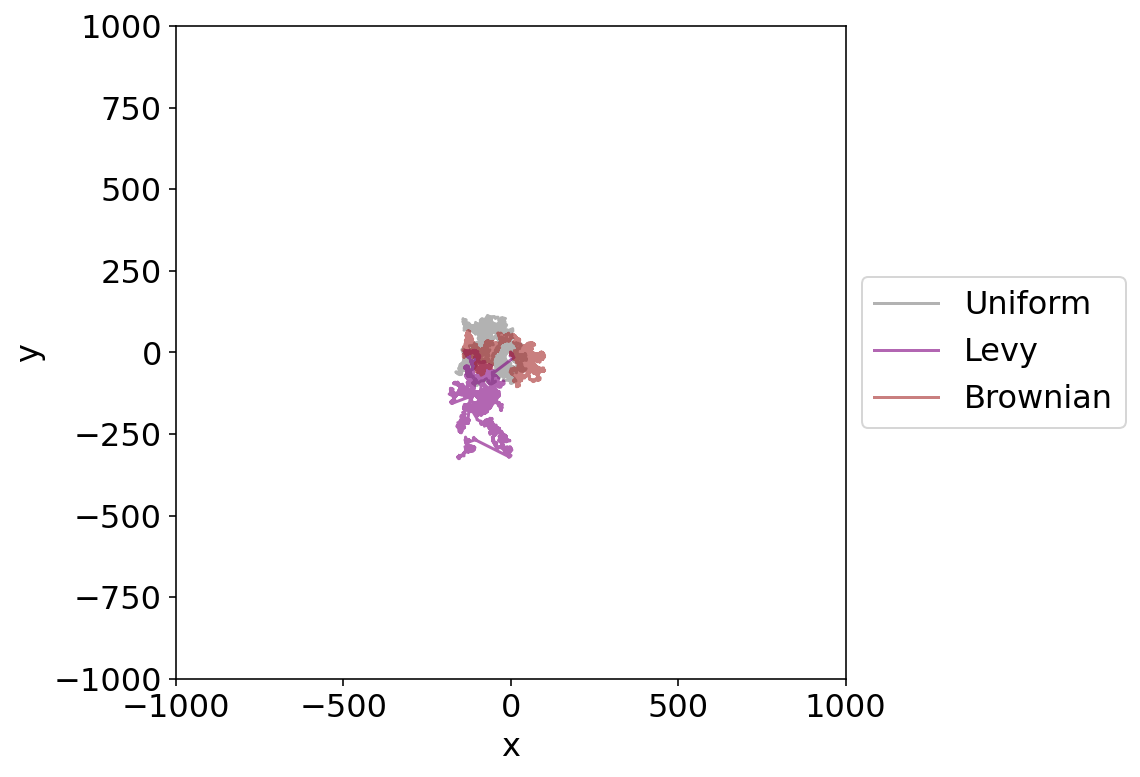

In [21]:
plot_boundary = (1000, 1000)

ax = plot_position2d(
    uni_exp,
    boundary=plot_boundary,
    label="Uniform",
    color="grey",
    alpha=0.6,
    figsize=(6, 6),
)
ax = plot_position2d(
    levy_exp,
    boundary=plot_boundary,
    label="Levy",
    color="purple",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    brown_exp,
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)

### plot loglog length distributions

- _Uniform_ should be flat(ish) still
- _Diffusion_ should drop of quick for large l
- _Levy_ should be a downward going straight line

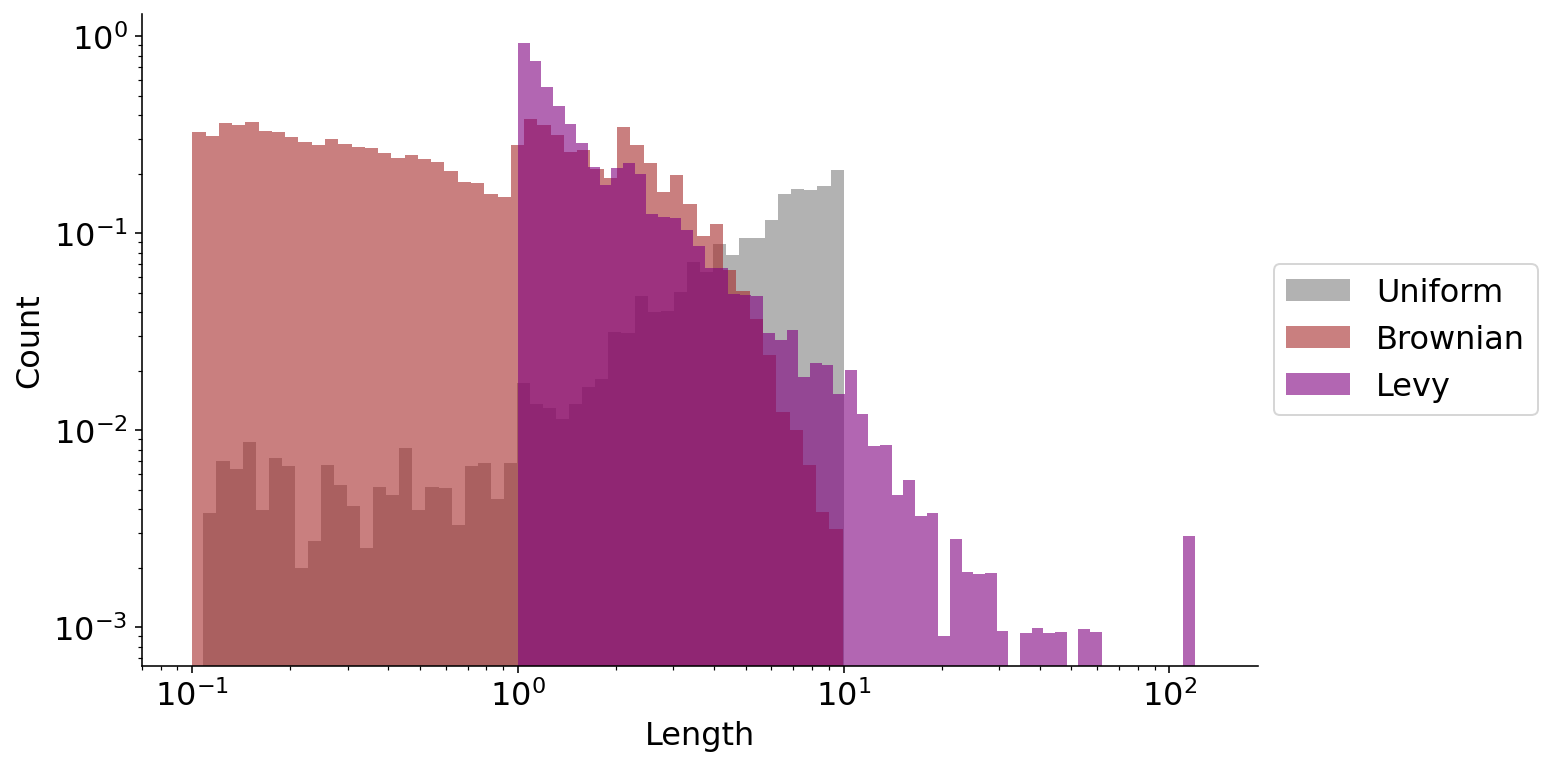

In [22]:
ax = plot_length_hist(
    uni_exp,
    loglog=True,
    bins=50,
    figsize=(10, 6),
    density=True,
    alpha=0.6,
    color="grey",
    label="Uniform",
)
ax = plot_length_hist(
    brown_exp,
    loglog=True,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Brownian",
    ax=ax,
)
ax = plot_length_hist(
    levy_exp,
    loglog=True,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)

sns.despine()

# Test - random search agents - 2
- Next use the `gym.Field` with various (bounded) target distributions. Verify target gathering performance across agents. 
- The parameter of interest here is the detection radius.

In [35]:
detection_radius = 0.5
target_boundary = (50, 50)

env = gym.Field()
targets = gym.uniform_targets(500, target_boundary)
values = gym.constant_values(targets, 1)

env.add_targets(targets, values, detection_radius=detection_radius)

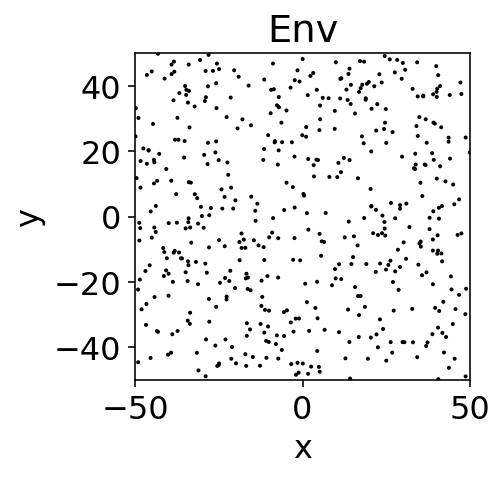

In [36]:
plot_targets2d(env, boundary=target_boundary, title="Env")

Values should be 1

In [37]:
values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Load agents

In [38]:
# Speed up the search w/ limits
min_l = 0.1
max_l = 5

# Init
brown = agent.Diffusion2d(min_l=min_l,
                          scale=0.5,
                          detection_radius=detection_radius)
levy2 = agent.TruncatedLevy2d(min_l=min_l,
                              max_l=max_l,
                              exponent=2,
                              detection_radius=detection_radius)

### Run 100 experiments
For _num_steps_.

In [39]:
num_experiments = 100
num_steps = 1000

In [40]:
# Cleanup old versions
for path in glob.glob("data/test2_*.pkl"):
    os.remove(path)

experiment(
    f"data/test2_levy2.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)
experiment(
    f"data/test2_brown.pkl",
    brown,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
)

### Load the results

In [41]:
# Dense
levy2 = load("data/test2_levy2.pkl")
brown = load("data/test2_brown.pkl")

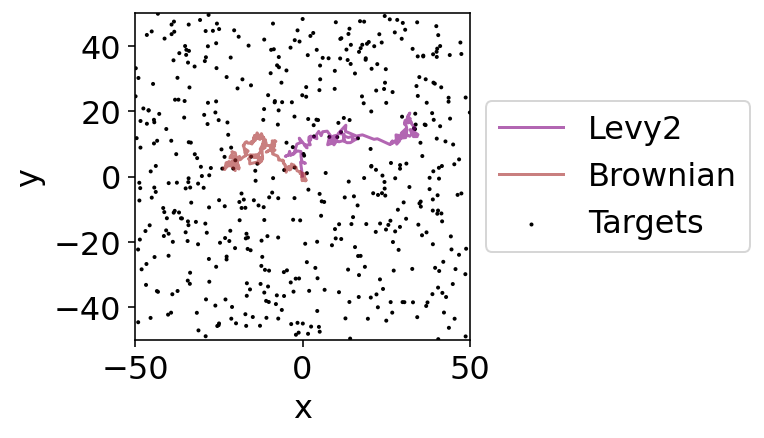

In [42]:
plot_boundary = (50, 50)

num_experiment = 3
ax = plot_position2d(
    select_exp(levy2, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(brown, num_experiment),
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Plot agents, by targets

In [43]:
names = ["Levy", "Brownian"]

# Score by eff
scores = []
for a in [levy2, brown]:
    r = search_efficiency(a)
    scores.append(r)

    # Tabulate
    m = []
    sd = []
    for i, s in enumerate(scores):
        m.append(np.mean(s))
        sd.append(np.std(s))

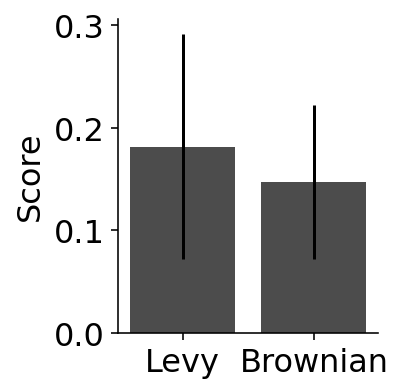

In [44]:
# Plot
fig = plt.figure(figsize=(3, 3))

plt.bar(names, m, yerr=sd, color="black", alpha=0.7)
plt.ylabel("Score")

plt.tight_layout()
sns.despine()

# Test - random search agents - 3
## Scan the Levy exponent
For sparse renewing targets, small detection radius, a classic ressult is optimal search eff at u=2. Prove that holds.

Params take from (as much as possible):

> Viswanathan, G. M. et al. Optimizing the success of random searches. Nature 401, 911–914 (1999).

In [ ]:
detection_radius = 0.25
target_boundary = (50, 50)

env = gym.Field()
targets = gym.uniform_targets(500, target_boundary)
values = gym.constant_values(targets, 1)

env.add_targets(targets, values, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

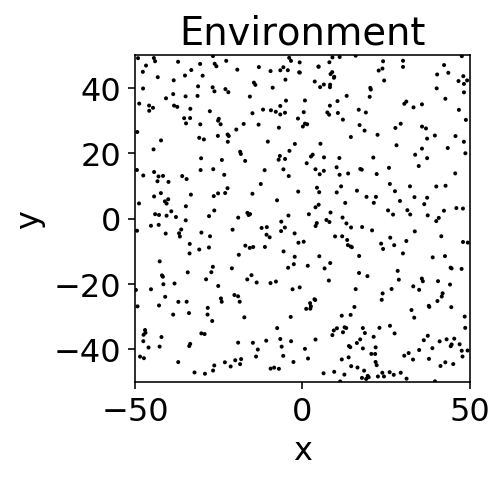

<IPython.core.display.Javascript object>

In [ ]:
plot_targets2d(env, boundary=target_boundary, title="Environment")

In [ ]:
# Params
num_experiments = 100
num_steps = 1000
exponents = [1.01, 1.50, 2.00, 2.50, 2.99]
# Speed up
min_l = 0.1
max_l = 10
seed = None

<IPython.core.display.Javascript object>

In [ ]:
# Cleanup old versions
for path in glob.glob("data/levy*_scan.pkl"):
    os.remove(path)


# !
scores = []
for x in exponents:
    # Init
    exp_name = f"data/levy{x}_scan.pkl"
    
    # Init
    levy = agent.TruncatedLevy2d(min_l=min_l,
                                 max_l=max_l,
                                 exponent=x,
                                 detection_radius=detection_radius)
    # Run repeats
    experiment(
        exp_name,
        levy,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed,
    )

levy2.99_scan: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


<IPython.core.display.Javascript object>

In [ ]:
# load
results = []
for i, x in enumerate(exponents):
    exp_data = load(f"data/levy{x}_scan.pkl")
    results.append(exp_data)

<IPython.core.display.Javascript object>

In [ ]:
[r["exp_name"] for r in results]

['levy1.01_scan',
 'levy1.5_scan',
 'levy2.0_scan',
 'levy2.5_scan',
 'levy2.99_scan']

<IPython.core.display.Javascript object>

## Visualize steps

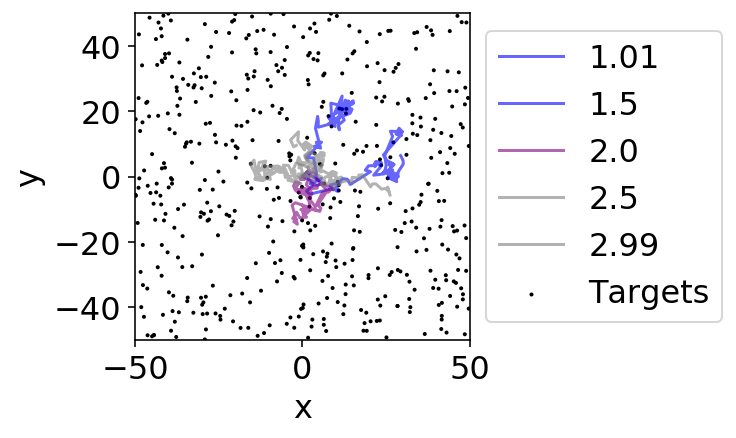

<IPython.core.display.Javascript object>

In [ ]:
num_experiment = 5
plot_boundary = (50, 50)

colors = ["blue", "blue", "purple", "grey", "grey"]
ax = None
for i, r in enumerate(results):
    ax = plot_position2d(
        select_exp(r, num_experiment),
        boundary=plot_boundary,
        label=str(exponents[i]),
        color=colors[i],
        alpha=0.6,
        figsize=(3, 3),
        ax=ax
    )

ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

## Length histogram

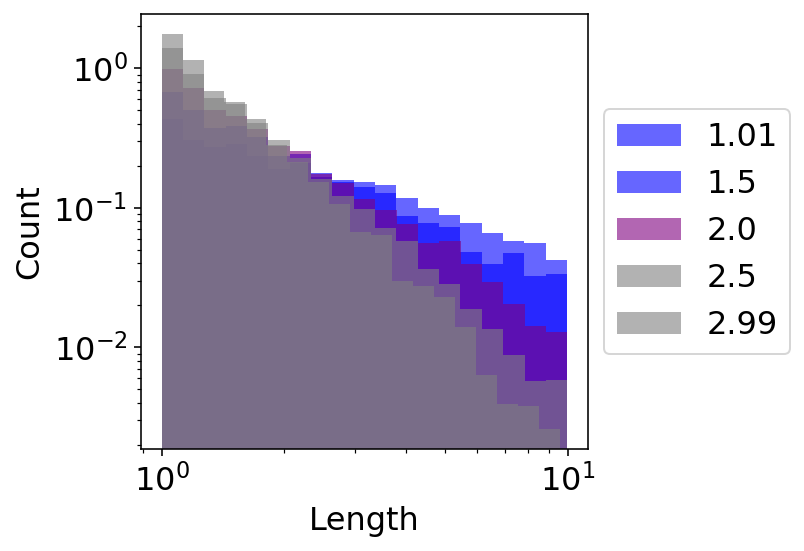

<IPython.core.display.Javascript object>

In [ ]:
num_experiment = 5
plot_boundary = (50, 50)

colors = ["blue", "blue", "purple", "grey", "grey"]
ax = None
for i, r in enumerate(results):
    ax = plot_length_hist(
        # r,
        select_exp(r, num_experiment),
        label=str(exponents[i]),
        color=colors[i],
        alpha=0.6,
        loglog=True,
        figsize=(4, 4),
        ax=ax
    )

## Search eff

In [ ]:
# Score by eff
scores = []
for r in results:
    eff = search_efficiency(r)
    scores.append(eff)

    # Tabulate
    m = []
    sd = []
    for i, s in enumerate(scores):
        m.append(np.mean(s))
        sd.append(np.std(s))

<IPython.core.display.Javascript object>

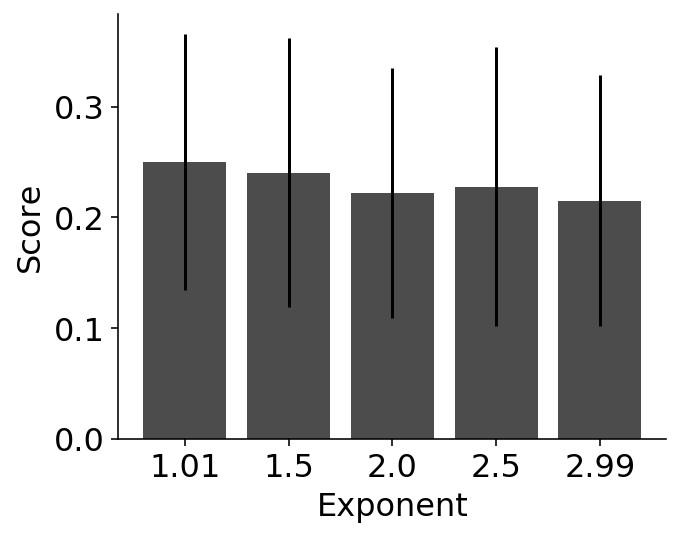

<IPython.core.display.Javascript object>

In [ ]:
# Plot
fig = plt.figure(figsize=(5, 4))

plt.bar([str(x) for x in exponents], m, yerr=sd, color="black", alpha=0.7)
plt.ylabel("Score")
plt.xlabel("Exponent")
plt.tight_layout()
sns.despine()